# Variational Auto-Encoder

In [2]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

import pickle
from tqdm import tqdm

In [3]:
# Importing data
dl_path = './MNIST'

# Run first time to download dataset
#mnist = fetch_openml('mnist_784', version=1, data_home=dl_path)

# After fetching and processing for the first time
#with open('./MNIST/mnist_processed.pkl', 'wb') as f:
#    pickle.dump(mnist, f)

# Pickled data for quick retrieval
with open('./MNIST/mnist_processed.pkl', 'rb') as f:
    mnist = pickle.load(f)

### Prepping data
- Resampling (undersampling to ensure equal distribution of labels)
- Splitting into train/test
- Scaling data to normalize
- Applying PCA

In [29]:
# Splitting into train/test data
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

# Undersampling training set to remove sampling bias
unique, counts = np.unique(y_train, return_counts=True)
min_samples = min(counts)

sample_ids = []
for u in unique :
    class_samples = y_train[y_train == u].index.to_numpy()

    random_indices = np.random.choice(len(class_samples), min_samples, replace=False)
    sample_ids.extend(class_samples[random_indices])

X_train, y_train = X_train.iloc[sample_ids], y_train.iloc[sample_ids]

# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values/255.0, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_test_tensor = torch.tensor(X_test.values/255.0, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [39]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean μ of the latent code
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance log(σ^2) of the latent code

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def vae_loss(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize the model, loss function, and optimizer
vae = VAE()

# Alternatively, load a pre-trained model saved under ./Models
vae = torch.load('vae_model.pth')

# Send to GPU if available
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
vae = vae.to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [57]:
# Training loop
num_epochs = 500

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = vae(data)
        loss = vae_loss(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader.dataset):.6f}")

# Save model
torch.save(vae, './Models/vae.pth')


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


Epoch: 1/500, Train Loss: 154.650882


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 2/500, Train Loss: 154.612427


100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch: 3/500, Train Loss: 154.609323


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch: 4/500, Train Loss: 154.660986


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch: 5/500, Train Loss: 154.665583


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 6/500, Train Loss: 154.760699


100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch: 7/500, Train Loss: 154.746568


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 8/500, Train Loss: 154.730262


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 9/500, Train Loss: 154.835624


100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch: 10/500, Train Loss: 155.060945


100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch: 11/500, Train Loss: 155.092948


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch: 12/500, Train Loss: 154.806337


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 13/500, Train Loss: 154.486890


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 14/500, Train Loss: 154.382196


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 15/500, Train Loss: 154.298737


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 16/500, Train Loss: 154.248019


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch: 17/500, Train Loss: 154.271744


100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch: 18/500, Train Loss: 154.225500


100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


Epoch: 19/500, Train Loss: 154.200755


100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch: 20/500, Train Loss: 154.227265


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 21/500, Train Loss: 154.243366


100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch: 22/500, Train Loss: 154.176216


100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch: 23/500, Train Loss: 154.126656


100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch: 24/500, Train Loss: 154.099376


100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch: 25/500, Train Loss: 154.158631


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 26/500, Train Loss: 154.280201


100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch: 27/500, Train Loss: 154.531118


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 28/500, Train Loss: 154.646922


100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch: 29/500, Train Loss: 154.309454


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 30/500, Train Loss: 154.107236


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 31/500, Train Loss: 153.963635


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 32/500, Train Loss: 153.851742


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 33/500, Train Loss: 153.809355


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 34/500, Train Loss: 153.773636


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 35/500, Train Loss: 153.750607


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch: 36/500, Train Loss: 153.792327


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 37/500, Train Loss: 153.821641


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 38/500, Train Loss: 153.871174


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 39/500, Train Loss: 154.015079


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 40/500, Train Loss: 154.310784


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 41/500, Train Loss: 154.217425


100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch: 42/500, Train Loss: 153.813944


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch: 43/500, Train Loss: 153.686994


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 44/500, Train Loss: 153.678666


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 45/500, Train Loss: 153.613600


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 46/500, Train Loss: 153.567204


100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch: 47/500, Train Loss: 153.565988


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch: 48/500, Train Loss: 153.616172


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 49/500, Train Loss: 153.712030


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 50/500, Train Loss: 153.720647


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 51/500, Train Loss: 153.714217


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 52/500, Train Loss: 153.735156


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 53/500, Train Loss: 153.650508


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 54/500, Train Loss: 153.559763


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 55/500, Train Loss: 153.585898


100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch: 56/500, Train Loss: 153.489835


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 57/500, Train Loss: 153.426858


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 58/500, Train Loss: 153.387563


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 59/500, Train Loss: 153.370629


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 60/500, Train Loss: 153.468950


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 61/500, Train Loss: 153.659769


100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch: 62/500, Train Loss: 153.672647


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 63/500, Train Loss: 153.308749


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 64/500, Train Loss: 153.251454


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch: 65/500, Train Loss: 153.238917


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 66/500, Train Loss: 153.218299


100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch: 67/500, Train Loss: 153.175556


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 68/500, Train Loss: 153.232380


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 69/500, Train Loss: 153.296315


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 70/500, Train Loss: 153.500866


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 71/500, Train Loss: 153.536648


100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch: 72/500, Train Loss: 153.307782


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 73/500, Train Loss: 153.142120


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 74/500, Train Loss: 153.043804


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 75/500, Train Loss: 153.005159


100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch: 76/500, Train Loss: 152.973412


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 77/500, Train Loss: 152.941147


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 78/500, Train Loss: 152.917685


100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch: 79/500, Train Loss: 152.880141


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 80/500, Train Loss: 152.894711


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 81/500, Train Loss: 152.960609


100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch: 82/500, Train Loss: 153.104723


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 83/500, Train Loss: 153.191730


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 84/500, Train Loss: 153.077899


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 85/500, Train Loss: 152.851403


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch: 86/500, Train Loss: 152.788553


100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch: 87/500, Train Loss: 152.840045


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 88/500, Train Loss: 152.887789


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 89/500, Train Loss: 152.913698


100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch: 90/500, Train Loss: 153.080540


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 91/500, Train Loss: 153.311068


100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch: 92/500, Train Loss: 153.361360


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 93/500, Train Loss: 152.882139


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 94/500, Train Loss: 152.635117


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 95/500, Train Loss: 152.557684


100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch: 96/500, Train Loss: 152.535225


100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch: 97/500, Train Loss: 152.504462


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 98/500, Train Loss: 152.517036


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 99/500, Train Loss: 152.596501


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 100/500, Train Loss: 152.602906


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 101/500, Train Loss: 152.629160


100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch: 102/500, Train Loss: 152.598115


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 103/500, Train Loss: 152.470402


100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch: 104/500, Train Loss: 152.452167


100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch: 105/500, Train Loss: 152.433938


100%|██████████| 7/7 [00:01<00:00,  6.52it/s]


Epoch: 106/500, Train Loss: 152.447050


100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


Epoch: 107/500, Train Loss: 152.478855


100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch: 108/500, Train Loss: 152.564184


100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch: 109/500, Train Loss: 152.606663


100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch: 110/500, Train Loss: 152.696267


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 111/500, Train Loss: 152.734717


100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Epoch: 112/500, Train Loss: 152.669172


100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch: 113/500, Train Loss: 152.576479


100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch: 114/500, Train Loss: 152.330024


100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch: 115/500, Train Loss: 152.191442


100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Epoch: 116/500, Train Loss: 152.181124


100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch: 117/500, Train Loss: 152.191750


100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch: 118/500, Train Loss: 152.261554


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch: 119/500, Train Loss: 152.243535


100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch: 120/500, Train Loss: 152.250766


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 121/500, Train Loss: 152.149632


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 122/500, Train Loss: 152.084719


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 123/500, Train Loss: 152.012947


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 124/500, Train Loss: 151.998997


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 125/500, Train Loss: 152.018148


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 126/500, Train Loss: 152.013821


100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch: 127/500, Train Loss: 151.983488


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 128/500, Train Loss: 151.990536


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 129/500, Train Loss: 152.047212


100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch: 130/500, Train Loss: 152.412275


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 131/500, Train Loss: 152.931150


100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch: 132/500, Train Loss: 152.284568


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 133/500, Train Loss: 152.110977


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 134/500, Train Loss: 152.262416


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 135/500, Train Loss: 152.259833


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 136/500, Train Loss: 152.315884


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch: 137/500, Train Loss: 152.309627


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 138/500, Train Loss: 152.160227


100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch: 139/500, Train Loss: 152.001583


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 140/500, Train Loss: 151.907210


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 141/500, Train Loss: 151.820279


100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch: 142/500, Train Loss: 151.814682


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 143/500, Train Loss: 151.752994


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 144/500, Train Loss: 151.735989


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 145/500, Train Loss: 151.661918


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 146/500, Train Loss: 151.630986


100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch: 147/500, Train Loss: 151.616412


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 148/500, Train Loss: 151.621375


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch: 149/500, Train Loss: 151.652557


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 150/500, Train Loss: 151.688680


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 151/500, Train Loss: 151.697795


100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch: 152/500, Train Loss: 151.791236


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 153/500, Train Loss: 151.939506


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 154/500, Train Loss: 152.143565


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 155/500, Train Loss: 152.235796


100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch: 156/500, Train Loss: 152.178404


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 157/500, Train Loss: 151.923678


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 158/500, Train Loss: 151.647873


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 159/500, Train Loss: 151.546479


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 160/500, Train Loss: 151.500137


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 161/500, Train Loss: 151.560339


100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch: 162/500, Train Loss: 151.592157


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 163/500, Train Loss: 151.673258


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 164/500, Train Loss: 151.733989


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 165/500, Train Loss: 151.689085


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 166/500, Train Loss: 151.520199


100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch: 167/500, Train Loss: 151.359871


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 168/500, Train Loss: 151.334288


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 169/500, Train Loss: 151.311973


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 170/500, Train Loss: 151.306445


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 171/500, Train Loss: 151.266208


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 172/500, Train Loss: 151.242525


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 173/500, Train Loss: 151.247201


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 174/500, Train Loss: 151.241905


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 175/500, Train Loss: 151.237318


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 176/500, Train Loss: 151.225947


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 177/500, Train Loss: 151.247997


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 178/500, Train Loss: 151.272386


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 179/500, Train Loss: 151.480688


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 180/500, Train Loss: 151.948831


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 181/500, Train Loss: 151.938365


100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch: 182/500, Train Loss: 151.281319


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 183/500, Train Loss: 151.279080


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 184/500, Train Loss: 151.304993


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 185/500, Train Loss: 151.490213


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 186/500, Train Loss: 151.553853


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch: 187/500, Train Loss: 151.590440


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 188/500, Train Loss: 151.398663


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 189/500, Train Loss: 151.212273


100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch: 190/500, Train Loss: 151.069496


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch: 191/500, Train Loss: 150.990130


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 192/500, Train Loss: 151.084255


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 193/500, Train Loss: 151.177229


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 194/500, Train Loss: 151.247845


100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch: 195/500, Train Loss: 151.158554


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 196/500, Train Loss: 150.939134


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 197/500, Train Loss: 150.907778


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 198/500, Train Loss: 150.918027


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 199/500, Train Loss: 150.901349


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch: 200/500, Train Loss: 150.834755


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 201/500, Train Loss: 150.851858


100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch: 202/500, Train Loss: 150.840397


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 203/500, Train Loss: 150.843864


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 204/500, Train Loss: 150.863556


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 205/500, Train Loss: 150.886271


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 206/500, Train Loss: 151.037590


100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch: 207/500, Train Loss: 151.261039


100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch: 208/500, Train Loss: 151.549382


100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch: 209/500, Train Loss: 151.578182


100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch: 210/500, Train Loss: 151.241408


100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch: 211/500, Train Loss: 151.069203


100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


Epoch: 212/500, Train Loss: 151.021077


100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch: 213/500, Train Loss: 150.804134


100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


Epoch: 214/500, Train Loss: 150.726646


100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch: 215/500, Train Loss: 150.674617


100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch: 216/500, Train Loss: 150.632301


100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch: 217/500, Train Loss: 150.690363


100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch: 218/500, Train Loss: 150.692172


100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch: 219/500, Train Loss: 150.568250


100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch: 220/500, Train Loss: 150.537869


100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch: 221/500, Train Loss: 150.530936


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 222/500, Train Loss: 150.533442


100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch: 223/500, Train Loss: 150.620721


100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch: 224/500, Train Loss: 150.642287


100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch: 225/500, Train Loss: 150.744929


100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch: 226/500, Train Loss: 150.943831


100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch: 227/500, Train Loss: 150.988193


100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch: 228/500, Train Loss: 150.860383


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch: 229/500, Train Loss: 150.852032


100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch: 230/500, Train Loss: 150.952944


100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch: 231/500, Train Loss: 151.041493


100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch: 232/500, Train Loss: 150.876284


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch: 233/500, Train Loss: 150.648244


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 234/500, Train Loss: 150.508948


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 235/500, Train Loss: 150.452763


100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch: 236/500, Train Loss: 150.396059


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 237/500, Train Loss: 150.346197


100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Epoch: 238/500, Train Loss: 150.326966


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 239/500, Train Loss: 150.329297


100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch: 240/500, Train Loss: 150.314703


100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch: 241/500, Train Loss: 150.330725


100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch: 242/500, Train Loss: 150.359427


100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch: 243/500, Train Loss: 150.496531


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 244/500, Train Loss: 150.657347


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 245/500, Train Loss: 150.815682


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 246/500, Train Loss: 150.581327


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch: 247/500, Train Loss: 150.327258


100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch: 248/500, Train Loss: 150.207859


100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch: 249/500, Train Loss: 150.235131


100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch: 250/500, Train Loss: 150.256730


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 251/500, Train Loss: 150.236606


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 252/500, Train Loss: 150.226051


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 253/500, Train Loss: 150.335648


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 254/500, Train Loss: 150.411232


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 255/500, Train Loss: 150.539735


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch: 256/500, Train Loss: 150.690144


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch: 257/500, Train Loss: 150.701611


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 258/500, Train Loss: 150.512172


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 259/500, Train Loss: 150.268501


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 260/500, Train Loss: 150.125735


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 261/500, Train Loss: 150.142490


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch: 262/500, Train Loss: 150.161819


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 263/500, Train Loss: 150.270347


100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch: 264/500, Train Loss: 150.315408


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 265/500, Train Loss: 150.512113


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 266/500, Train Loss: 150.347887


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 267/500, Train Loss: 150.102111


100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch: 268/500, Train Loss: 150.017976


100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch: 269/500, Train Loss: 150.038932


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch: 270/500, Train Loss: 150.035373


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 271/500, Train Loss: 150.037575


100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch: 272/500, Train Loss: 150.157349


100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch: 273/500, Train Loss: 150.302322


100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch: 274/500, Train Loss: 150.227424


100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch: 275/500, Train Loss: 150.135435


100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch: 276/500, Train Loss: 150.018285


100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch: 277/500, Train Loss: 150.039930


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 278/500, Train Loss: 150.046802


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch: 279/500, Train Loss: 150.085077


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 280/500, Train Loss: 150.034875


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 281/500, Train Loss: 149.990813


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch: 282/500, Train Loss: 149.948913


100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch: 283/500, Train Loss: 149.903276


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 284/500, Train Loss: 149.853193


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 285/500, Train Loss: 149.822384


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 286/500, Train Loss: 149.903362


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch: 287/500, Train Loss: 150.040561


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 288/500, Train Loss: 150.271784


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 289/500, Train Loss: 150.071936


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 290/500, Train Loss: 149.839325


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch: 291/500, Train Loss: 149.784370


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 292/500, Train Loss: 149.740291


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 293/500, Train Loss: 149.783743


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 294/500, Train Loss: 149.856054


100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch: 295/500, Train Loss: 149.896494


100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 296/500, Train Loss: 149.916584


100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch: 297/500, Train Loss: 149.859332


100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch: 298/500, Train Loss: 149.904540


100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


Epoch: 299/500, Train Loss: 149.885524


100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


Epoch: 300/500, Train Loss: 149.828965


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 301/500, Train Loss: 149.699020


100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch: 302/500, Train Loss: 149.664927


100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


Epoch: 303/500, Train Loss: 149.614223


100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch: 304/500, Train Loss: 149.643392


100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch: 305/500, Train Loss: 149.769967


100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


Epoch: 306/500, Train Loss: 150.022471


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 307/500, Train Loss: 150.115468


100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch: 308/500, Train Loss: 149.918912


100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch: 309/500, Train Loss: 149.552825


100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch: 310/500, Train Loss: 149.506651


100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


Epoch: 311/500, Train Loss: 149.493237


100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch: 312/500, Train Loss: 149.609204


100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch: 313/500, Train Loss: 149.650143


100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch: 314/500, Train Loss: 149.616395


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch: 315/500, Train Loss: 149.664487


100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch: 316/500, Train Loss: 149.830304


100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch: 317/500, Train Loss: 149.989053


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch: 318/500, Train Loss: 150.031919


100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch: 319/500, Train Loss: 149.905145


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch: 320/500, Train Loss: 149.570371


100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Epoch: 321/500, Train Loss: 149.417950


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch: 322/500, Train Loss: 149.340346


100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch: 323/500, Train Loss: 149.316040


100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


Epoch: 324/500, Train Loss: 149.365301


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch: 325/500, Train Loss: 149.390397


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 326/500, Train Loss: 149.505493


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch: 327/500, Train Loss: 149.554907


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch: 328/500, Train Loss: 149.561819


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch: 329/500, Train Loss: 149.603869


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 330/500, Train Loss: 149.449042


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 331/500, Train Loss: 149.333074


100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch: 332/500, Train Loss: 149.279076


100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch: 333/500, Train Loss: 149.254765


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch: 334/500, Train Loss: 149.264712


100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


Epoch: 335/500, Train Loss: 149.235736


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 336/500, Train Loss: 149.253446


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch: 337/500, Train Loss: 149.322879


100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch: 338/500, Train Loss: 149.429077


100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch: 339/500, Train Loss: 149.600172


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 340/500, Train Loss: 149.763887


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 341/500, Train Loss: 149.938899


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 342/500, Train Loss: 149.856060


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 343/500, Train Loss: 149.439409


100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch: 344/500, Train Loss: 149.228577


100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch: 345/500, Train Loss: 149.181354


100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch: 346/500, Train Loss: 149.231852


100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch: 347/500, Train Loss: 149.331612


100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


Epoch: 348/500, Train Loss: 149.646910


100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch: 349/500, Train Loss: 149.854186


100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch: 350/500, Train Loss: 149.413603


100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch: 351/500, Train Loss: 149.173279


100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch: 352/500, Train Loss: 149.095921


100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch: 353/500, Train Loss: 149.064907


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 354/500, Train Loss: 149.059797


100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch: 355/500, Train Loss: 149.019498


100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch: 356/500, Train Loss: 149.074290


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 357/500, Train Loss: 149.075791


100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch: 358/500, Train Loss: 149.109308


100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch: 359/500, Train Loss: 149.234603


100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch: 360/500, Train Loss: 149.480632


100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch: 361/500, Train Loss: 149.403917


100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch: 362/500, Train Loss: 149.118349


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 363/500, Train Loss: 149.025255


100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch: 364/500, Train Loss: 149.025066


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 365/500, Train Loss: 149.019649


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 366/500, Train Loss: 149.046027


100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch: 367/500, Train Loss: 149.101481


100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch: 368/500, Train Loss: 149.263281


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 369/500, Train Loss: 149.439685


100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch: 370/500, Train Loss: 149.504370


100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Epoch: 371/500, Train Loss: 149.445294


100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch: 372/500, Train Loss: 149.220232


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 373/500, Train Loss: 149.043414


100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch: 374/500, Train Loss: 148.957732


100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch: 375/500, Train Loss: 149.086225


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch: 376/500, Train Loss: 149.275079


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch: 377/500, Train Loss: 149.165584


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 378/500, Train Loss: 148.940755


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 379/500, Train Loss: 148.841225


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 380/500, Train Loss: 148.811581


100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


Epoch: 381/500, Train Loss: 148.799812


100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch: 382/500, Train Loss: 148.798215


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 383/500, Train Loss: 148.793364


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 384/500, Train Loss: 148.840951


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 385/500, Train Loss: 148.839591


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 386/500, Train Loss: 148.943329


100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch: 387/500, Train Loss: 149.042856


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 388/500, Train Loss: 149.005691


100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch: 389/500, Train Loss: 149.073204


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 390/500, Train Loss: 149.004215


100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Epoch: 391/500, Train Loss: 148.968193


100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch: 392/500, Train Loss: 149.022703


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 393/500, Train Loss: 149.078147


100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch: 394/500, Train Loss: 149.077698


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 395/500, Train Loss: 149.040902


100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch: 396/500, Train Loss: 148.951272


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 397/500, Train Loss: 148.841634


100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Epoch: 398/500, Train Loss: 148.739755


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 399/500, Train Loss: 148.692653


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch: 400/500, Train Loss: 148.599864


100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch: 401/500, Train Loss: 148.577080


100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch: 402/500, Train Loss: 148.594411


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 403/500, Train Loss: 148.585407


100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch: 404/500, Train Loss: 148.616823


100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch: 405/500, Train Loss: 148.679370


100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch: 406/500, Train Loss: 149.117769


100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch: 407/500, Train Loss: 149.457073


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch: 408/500, Train Loss: 149.107762


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 409/500, Train Loss: 148.620179


100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch: 410/500, Train Loss: 148.650560


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch: 411/500, Train Loss: 148.647907


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 412/500, Train Loss: 148.656633


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch: 413/500, Train Loss: 148.589903


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch: 414/500, Train Loss: 148.658684


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch: 415/500, Train Loss: 148.788227


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 416/500, Train Loss: 148.938433


100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


Epoch: 417/500, Train Loss: 149.055595


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 418/500, Train Loss: 148.913310


100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch: 419/500, Train Loss: 148.579869


100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch: 420/500, Train Loss: 148.407251


100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch: 421/500, Train Loss: 148.375020


100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch: 422/500, Train Loss: 148.428488


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch: 423/500, Train Loss: 148.677627


100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch: 424/500, Train Loss: 149.051400


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 425/500, Train Loss: 148.880246


100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch: 426/500, Train Loss: 148.367691


100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch: 427/500, Train Loss: 148.394087


100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch: 428/500, Train Loss: 148.499579


100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch: 429/500, Train Loss: 148.353354


100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch: 430/500, Train Loss: 148.270412


100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch: 431/500, Train Loss: 148.270334


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 432/500, Train Loss: 148.257749


100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch: 433/500, Train Loss: 148.276048


100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch: 434/500, Train Loss: 148.315580


100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch: 435/500, Train Loss: 148.318098


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 436/500, Train Loss: 148.308170


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 437/500, Train Loss: 148.359909


100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


Epoch: 438/500, Train Loss: 148.432920


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch: 439/500, Train Loss: 148.538727


100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


Epoch: 440/500, Train Loss: 148.662905


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 441/500, Train Loss: 148.755922


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 442/500, Train Loss: 148.836014


100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch: 443/500, Train Loss: 148.764760


100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch: 444/500, Train Loss: 148.527150


100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch: 445/500, Train Loss: 148.298195


100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch: 446/500, Train Loss: 148.165030


100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch: 447/500, Train Loss: 148.155326


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 448/500, Train Loss: 148.144153


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 449/500, Train Loss: 148.137492


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch: 450/500, Train Loss: 148.316308


100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch: 451/500, Train Loss: 148.596602


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 452/500, Train Loss: 149.074355


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 453/500, Train Loss: 149.059625


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 454/500, Train Loss: 148.285823


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch: 455/500, Train Loss: 148.112086


100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch: 456/500, Train Loss: 148.222330


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 457/500, Train Loss: 148.152470


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 458/500, Train Loss: 148.073775


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch: 459/500, Train Loss: 148.027537


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch: 460/500, Train Loss: 148.052074


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 461/500, Train Loss: 148.098688


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch: 462/500, Train Loss: 148.298979


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 463/500, Train Loss: 148.542158


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 464/500, Train Loss: 148.541619


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 465/500, Train Loss: 148.309032


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 466/500, Train Loss: 148.422421


100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch: 467/500, Train Loss: 148.549441


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 468/500, Train Loss: 148.629800


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 469/500, Train Loss: 148.440656


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 470/500, Train Loss: 148.256684


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 471/500, Train Loss: 148.103007


100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch: 472/500, Train Loss: 147.992027


100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch: 473/500, Train Loss: 147.925260


100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch: 474/500, Train Loss: 147.886873


100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch: 475/500, Train Loss: 147.876217


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 476/500, Train Loss: 147.901821


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 477/500, Train Loss: 147.981555


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch: 478/500, Train Loss: 148.014813


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch: 479/500, Train Loss: 148.180270


100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch: 480/500, Train Loss: 148.453546


100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch: 481/500, Train Loss: 148.492326


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch: 482/500, Train Loss: 148.087668


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 483/500, Train Loss: 147.947391


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 484/500, Train Loss: 147.894665


100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch: 485/500, Train Loss: 147.902017


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 486/500, Train Loss: 147.962463


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch: 487/500, Train Loss: 148.015064


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch: 488/500, Train Loss: 148.128835


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 489/500, Train Loss: 148.423813


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch: 490/500, Train Loss: 148.595297


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch: 491/500, Train Loss: 148.576732


100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch: 492/500, Train Loss: 148.212666


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch: 493/500, Train Loss: 147.957743


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch: 494/500, Train Loss: 147.828293


100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch: 495/500, Train Loss: 147.809803


100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch: 496/500, Train Loss: 147.810327


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch: 497/500, Train Loss: 147.826264


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 498/500, Train Loss: 147.980961


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch: 499/500, Train Loss: 148.262042


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

Epoch: 500/500, Train Loss: 148.495697


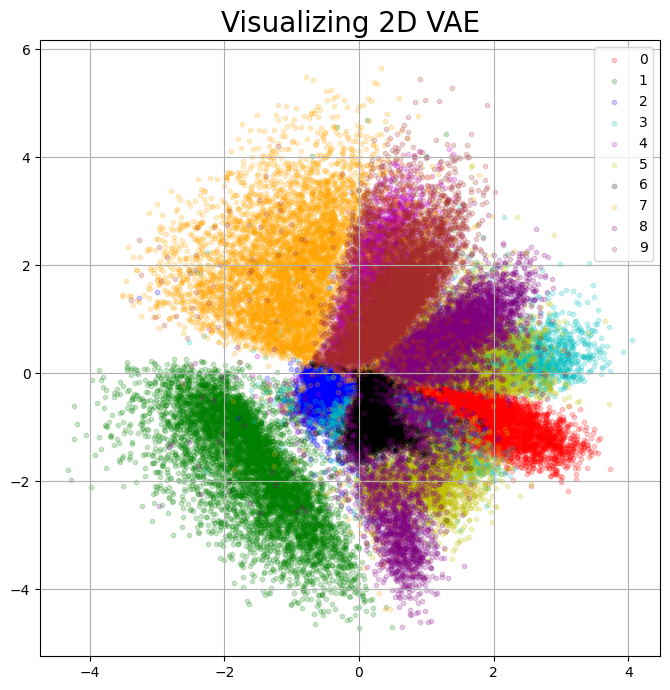

In [58]:
# Visualizing results 
x1 = vae.encode(train_dataset.tensors[0].to(device))[0].T[0].cpu().detach().numpy()
x2 = vae.encode(train_dataset.tensors[0].to(device))[0].T[1].cpu().detach().numpy()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('Visualizing 2D VAE', fontsize = 20)

targets = list(range(10))  # assuming the labels are integers from 0 to 9
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

for target, color in zip(targets, colors):
    indicesToKeep = train_dataset.tensors[1] == target
    ax.scatter(x1[indicesToKeep], x2[indicesToKeep], c=color, alpha=0.2, s=10)

ax.legend(targets)
ax.grid()

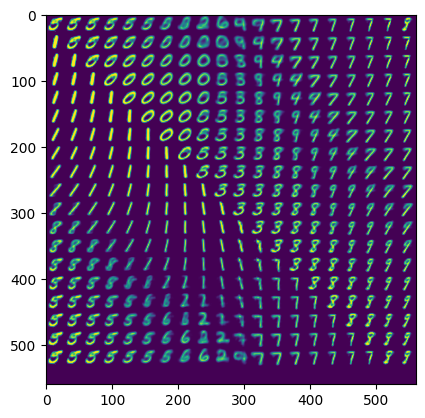

In [61]:
# Generating samples
n, m = 20, 20
x1, x2 = np.meshgrid(np.linspace(-4, 4, n), np.linspace(-4,4,m))
mesh_points = np.c_[x1.ravel(), x2.ravel()]

img_arr = np.zeros((n * 28, m * 28))

for i, point in enumerate(mesh_points) : 
    sample = vae.decode(torch.tensor(point, dtype=torch.float32, device=device))
    sample_img = sample.reshape(28,28).cpu().detach().numpy()
    img_arr[28 * (i % (n-1)) : 28 * (i % (n-1) +1), (i // m) * 28 : 28 * (i // m + 1)] = sample_img

plt.imshow(img_arr)

## VAE with PCA

In [358]:
# Applying PCA to data
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

pca_dimensions = pca.n_components_

#scaler = StandardScaler()
#train_features = scaler.fit_transform(X_train_pca)
#test_features = scaler.transform(X_test_pca)

# Normalizing data to lie within [0,1] using min-max scaling
min_val, max_val = X_train_pca.min(), X_train_pca.max()

train_features = (X_train_pca - min_val) / (max_val - min_val)
test_features = (X_test_pca - min_val) / (max_val - min_val)

# Converting to tensors
X_train_tensor = torch.tensor(train_features, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_test_tensor = torch.tensor(test_features, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

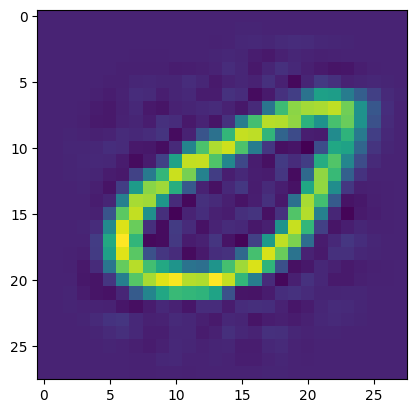

In [359]:
denormalized_X = train_features * (max_val - min_val) + min_val
plt.imshow(pca.inverse_transform(denormalized_X)[1].reshape(28,28))

In [363]:
n=0
print()
train_features[0]

array([0.65327237, 0.33017076, 0.39186339, 0.63450248, 0.18849947,
       0.42876465, 0.47493314, 0.41589913, 0.31769988, 0.44569718,
       0.34232741, 0.5427717 , 0.2735422 , 0.45430781, 0.36326374,
       0.44284961, 0.46920973, 0.35772319, 0.43072747, 0.43177551,
       0.2779979 , 0.34556714, 0.3673967 , 0.36896829, 0.35245604,
       0.4269464 , 0.42030876, 0.34631587, 0.36403476, 0.38144457,
       0.39436912, 0.39109599, 0.40884755, 0.38300016, 0.4871841 ,
       0.41872971, 0.37633579, 0.36418483, 0.41405528, 0.41991174,
       0.39596192, 0.30414939, 0.39729854, 0.36813151, 0.36464361,
       0.41975017, 0.35657725, 0.31284029, 0.44419852, 0.36468927,
       0.34570374, 0.41858293, 0.40934067, 0.43751675, 0.38384324,
       0.32478367, 0.42571499, 0.39467123, 0.39140373, 0.39218912,
       0.37074062, 0.41934839, 0.35226367, 0.39154642, 0.39920226,
       0.41929029, 0.40158932, 0.38960823, 0.38865246, 0.38636844,
       0.4081941 , 0.383557  , 0.37667653, 0.37911622, 0.35123

In [360]:
# Defining VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(pca_dimensions, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean μ of the latent code
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance log(σ^2) of the latent code

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, pca_dimensions)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, pca_dimensions))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def vae_loss(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, pca_dimensions), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [361]:
# Initialize the model, loss function, and optimizer
pca_vae = VAE()
if torch.cuda.is_available():
    pca_vae = pca_vae.cuda()

optimizer = torch.optim.Adam(pca_vae.parameters(), lr=0.01)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    pca_vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = pca_vae(data)
        loss = vae_loss(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader.dataset):.6f}")

Epoch: 1/1000, Train Loss: 102.847687
Epoch: 2/1000, Train Loss: 102.761536
Epoch: 3/1000, Train Loss: 102.759228
Epoch: 4/1000, Train Loss: 102.758965
Epoch: 5/1000, Train Loss: 102.758999
Epoch: 6/1000, Train Loss: 102.759002


KeyboardInterrupt: 

In [331]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda() if torch.cuda.is_available() else torch.randn(64, 2)
    samples = pca_vae.decode(z).cpu()

In [332]:
samples.shape

torch.Size([64, 151])

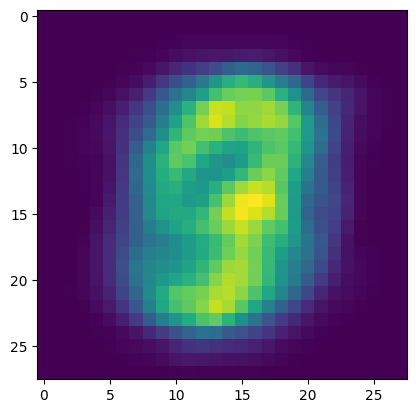

In [336]:
denormalized_samples = samples * (max_val - min_val) + min_val
plt.imshow(pca.inverse_transform(denormalized_samples)[1].reshape(28,28))

In [166]:
X_train_pca.shape

(900, 129)

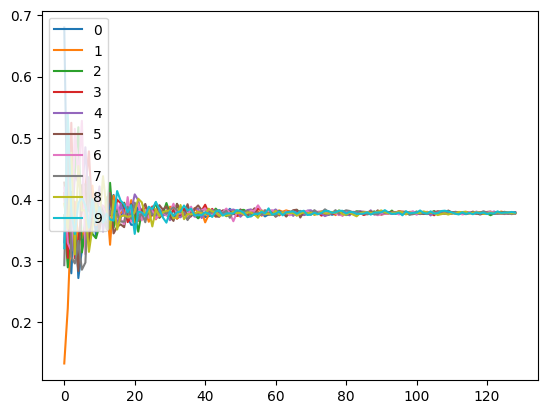

In [194]:
f, ax = plt.subplots()
for label in '0123456789': 
    keepIndices = y_train == label
    ax.plot(X_train_pca[keepIndices].sum(axis=0)/X_train_pca[keepIndices].shape[0], label=label)

ax.legend()

In [171]:
y_train[0]

'5'